In [1]:
import os
import itertools
import logging
import psutil

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from zoopt import Dimension, Objective, Parameter, Opt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

2024-08-29 14:28:42.099174: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 14:28:42.106789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 14:28:42.115099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 14:28:42.117532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 14:28:42.124318: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set memory growth on GPUs to prevent TensorFlow from consuming all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1724921924.180764  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724921924.217354  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724921924.222155  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10
K = 5

In [4]:
def loading_data(dataset_path):
    filepaths = []
    labels = []

    folds = os.listdir(dataset_path)
    for fold in folds:
        foldpath = os.path.join(dataset_path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepath')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [5]:
def change_label_name(df, column_name):
    index = {'normal': 'Normal', 'bact_pneumo': 'Bacterial_Pneumonia', 'viral_pneumo': 'Viral_Pneumonia'}
    df[column_name] = df[column_name].replace(index)

dataset_path = "/home/idrone2/Desktop/chest_xray"
df = loading_data(dataset_path)

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

change_label_name(df, 'labels')
df


Found 5856 files belonging to 3 classes.


I0000 00:00:1724921928.533972  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724921928.538890  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724921928.549295  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724921928.672253  603088 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

,filepath,labels
0,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
1,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
2,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
3,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
4,/home/idrone2/Desktop/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
...,...,...
5851,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5852,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5853,/home/idrone2/Desktop/chest_xray/normal/NORMAL...,Normal
5854,/home/idrone2/Desktop/chest_xray/normal/IM-069...,Normal


In [6]:
# Check the unique labels in the dataset
print(df['labels'].unique())


['Bacterial_Pneumonia' 'Viral_Pneumonia' 'Normal']


In [7]:
# Dynamically create class_names list based on the unique labels in the dataset
class_names = list(df['labels'].unique())


In [8]:
class_names = image_dataset.class_names
data_balance = df.labels.value_counts()


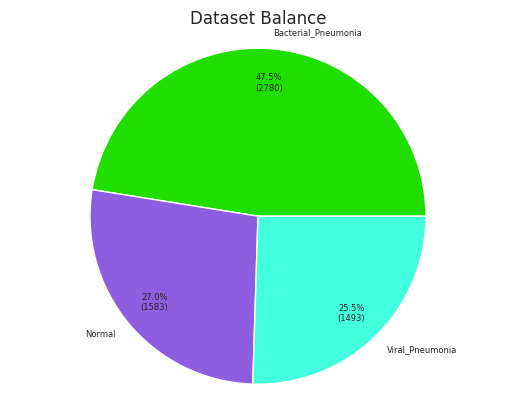

In [9]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

colors = ['#20df00', '#8f5ddf', '#44ffdd']
plt.pie(data_balance, autopct=custom_autopct, labels=data_balance.index, colors=colors, textprops={'fontsize': 6}, pctdistance=0.8, labeldistance=1.1)
plt.title("Dataset Balance")
plt.axis("equal")
plt.show()

In [10]:
# K-Fold Cross Validation
kf = KFold(n_splits=K, shuffle=True, random_state=123)

for fold, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    valid_df, test_df = train_test_split(test_df, test_size=0.8)

In [11]:
# Prepare data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [12]:
# Log memory usage
def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / (1024 ** 3):.2f} GB")

In [13]:
# Function to preprocess dataset
def preprocess(ds):
    return ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
def load_and_preprocess_image(dataset_path):
    # Read the image file
    image = tf.io.read_file(dataset_path)
    
    # Decode the image (assuming images are JPEGs, or change to PNG if applicable)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize the image to the required size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Normalize the pixel values to [0, 1]
    image = image / 255.0
    
    return image


In [15]:
print(dataset_path)  # To ensure the paths are valid


/home/idrone2/Desktop/chest_xray


In [16]:
def image_dataset_from_dataframe(df):
    # Ensure that class_names includes all possible labels
    class_names = list(df['labels'].unique())  # Dynamically generate class_names

    # Convert file paths and labels to TensorFlow datasets
    dataset_path = df['filepath'].values
    labels = df['labels'].apply(lambda x: class_names.index(x)).values  # Convert labels to class indices
    
    # Create a dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((dataset_path, labels))
    
    # Map the dataset to load and preprocess images
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch the dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


In [17]:
def create_model(num_layers, filters_1, units, learning_rate, dropout_rate):
  model = models.Sequential()
  model.add(tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
  model.add(tf.keras.layers.Rescaling(1./255))

  # Add the first convolutional layer
  model.add(layers.Conv2D(filters_1, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
  model.add(layers.MaxPooling2D((2, 2)))

  # Add remaining convolutional layers
  for _ in range(num_layers - 2):
    model.add(layers.Conv2D( kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))  # Add dropout for regularization

  # Add final layers
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(units, activation='relu'))
  model.add(layers.Dense(len(class_names), activation='softmax'))

  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
  )
  return model

In [18]:

def cnn_fitness(solution):
    log_memory_usage()  # Log memory usage before training starts
    params = solution.get_x()
    EPOCHS = int(params[0])
    filters_1 = int(params[1])
    units = int(params[2])
    learning_rate = params[3]
    num_layers = int(params[4])
    dropout_rate = params[5]
  

    accuracy = []

    for train_index, val_index in KFold(n_splits=K, shuffle=True, random_state=123).split(df):
        print(f"Training fold with {EPOCHS} epochs, filters_1: {filters_1},  units: {units}, learning_rate: {learning_rate}, num_layers: {num_layers}, dropout_rate: {dropout_rate}...")
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]

        train_ds = image_dataset_from_dataframe(train_df)
        val_ds = image_dataset_from_dataframe(val_df)

        train_ds = preprocess(train_ds)
        val_ds = preprocess(val_ds)

        model = create_model(num_layers, filters_1, units, learning_rate, dropout_rate)

        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=val_ds,
            verbose=0
        )

        accuracy.append(history.history['val_accuracy'][-1])

        # Clear the Keras session to free up GPU memory
        tf.keras.backend.clear_session()
        log_memory_usage()  # Log memory usage after each fold

    return -np.mean(accuracy)

In [19]:
import zoopt as zp
import zoopt.opt as opt

In [20]:

# Define the search space for hyperparameters
dim = zp.Dimension(8,
                [
                    [10, 20],  # EPOCHS
                    [32, 128],  # filters_1
                    [32, 128],  # filters_2
                    [32, 256],  # units
                    [1e-3, 0.1],  # learning_rate
                    [2, 5],     # num_layers
                    [0.2, 0.5],  # dropout_rate
                    [32, 128]  # filters_per_layer
                 ],
                [True, True, True, True, True, True, True, True])

# Define the objective function
objective = zp.Objective(cnn_fitness, dim)

# Set optimization parameters (budget: number of evaluations)
parameter = zp.Parameter(budget=20)  # Adjust budget based on your needs

print("Starting optimization...")
# Perform the optimization
solution = zp.Opt.min(objective, parameter)  # Corrected line: use zp.opt.min()
print("Best hyperparameters: ", solution.get_x())
print("Best validation accuracy: ", -solution.get_value())

# Train final model with optimized hyperparameters
best_params = solution.get_x()
best_epochs = int(best_params[0])
best_filters_1 = int(best_params[1])
best_filters_2 = int(best_params[2])
best_units = int(best_params[3])
best_learning_rate = best_params[4]
best_dropout_rate = best_params[5]
best_filters_per_layer = best_params[6]

print("Training final model with best parameters...")
# Example: Train final model with the best parameters
final_model = create_model(best_filters_1, best_filters_2, best_units, best_learning_rate, best_dropout_rate, best_filters_per_layer)
history = final_model.fit(
    preprocess(image_dataset),
    epochs=best_epochs,
    verbose=1,
)
print("Training complete.")

Starting optimization...
Memory usage: 0.90 GB
Training fold with 13 epochs, filters_1: 68,  units: 36, learning_rate: 45.913561083675916, num_layers: 0, dropout_rate: 4.618523150643417...


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724921940.996499  603279 service.cc:146] XLA service 0x7a549834cb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724921940.996530  603279 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2024-08-29 14:29:01.008820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 14:29:01.078253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1724921950.605805  603279 device_

Memory usage: 2.59 GB
Training fold with 13 epochs, filters_1: 68,  units: 36, learning_rate: 45.913561083675916, num_layers: 0, dropout_rate: 4.618523150643417...
Memory usage: 2.76 GB
Training fold with 13 epochs, filters_1: 68,  units: 36, learning_rate: 45.913561083675916, num_layers: 0, dropout_rate: 4.618523150643417...
Memory usage: 2.83 GB
Training fold with 13 epochs, filters_1: 68,  units: 36, learning_rate: 45.913561083675916, num_layers: 0, dropout_rate: 4.618523150643417...
Memory usage: 2.91 GB
Training fold with 13 epochs, filters_1: 68,  units: 36, learning_rate: 45.913561083675916, num_layers: 0, dropout_rate: 4.618523150643417...
Memory usage: 2.97 GB
Memory usage: 2.97 GB
Training fold with 14 epochs, filters_1: 42,  units: 56, learning_rate: 201.47547138104062, num_layers: 0, dropout_rate: 2.5011630842403014...
Memory usage: 3.11 GB
Training fold with 14 epochs, filters_1: 42,  units: 56, learning_rate: 201.47547138104062, num_layers: 0, dropout_rate: 2.501163084240

2024-08-29 16:28:41.625937: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB (rounded to 1850222592)requested by op 
2024-08-29 16:28:41.625968: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-08-29 16:28:41.625972: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 365, Chunks in use: 365. 91.2KiB allocated for chunks. 91.2KiB in use in bin. 30.6KiB client-requested in use in bin.
2024-08-29 16:28:41.625975: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 149, Chunks in use: 149. 78.5KiB allocated for chunks. 78.5KiB in use in bin. 56.4KiB client-requested in use in bin.
2024-08-29 16:28:41.625977: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 54, Chunks in use: 54. 71.0KiB allocated for chunks. 71.0KiB in use in bin. 62.8KiB client-requested in use in bin.
2

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/idrone2/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_603088/535917153.py", line 23, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/opt.py", line 50, in min

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/racos_optimization.py", line 57, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/sracos.py", line 77, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/objective.py", line 83, in eval

  File "/tmp/ipykernel_603088/3979997087.py", line 27, in cnn_fitness

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 1850222448 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_202044]